**CONSIGNAS PARA TODOS LOS EJERCICIOS:**

1.   En el caso de utilizar una Regresión Logística grafique sus parámetros con la función AA_utils.visualizar_parametros
2.   Grafique e interprete la matriz de confusión de la predicción sobre el set de test con la función AA_utils.visualizar_confusion_matrix
3.   Elabore un reporte de métricas tanto para la predicción de train como para la de test con la función AA_utils.print_classification_report
4.   En los casos de clasificación binaria grafique e interprete la curva ROC con la función AA_utils.visualizar_curva_ROC
5.   En los caso de clasificación de dos variables grafique la función de transferencia y la frontera de decisión con las funciones AA_utils.visualizar_funcion_transferencia_2D y AA_utils.visualizar_frontera_de_desicion_2D
6.   En los casos de clasificación binaria de una variable grafique la curva logística con la función AA_utils.visualizar_curva_logistica

# **NAFTA**

**Regresión con Redes Neuronales:** Analice el código en el archivo “Redes_neuro_regresion_Nafta.py”. El script entrena una red neuronal para predecir el consumo de un vehículo en base a la velocidad a la que circula. Analice la curva entrenada y las métricas obtenidas. ¿Qué ocurre si no normaliza las variables?

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, classification_report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# **AA UTILS**

In [126]:
def if_dataframe_to_numpy(data):
    return data.to_numpy() if isinstance(data, pd.DataFrame) or isinstance(data, pd.Series) else data

def plot_2d(modelo, X, X_train, X_test, y_train, y_test, boundry_function):

    assert X.shape[1] == 2, f"X debe tener solo dos variables de entrada (tiene {X.shape[1]})"

    X = if_dataframe_to_numpy(X)
    X_train = if_dataframe_to_numpy(X_train)
    X_test = if_dataframe_to_numpy(X_test)

    plt.figure()
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    Z = np.c_[xx.ravel(), yy.ravel()]
    Z = boundry_function(modelo, Z)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.colorbar()

    plt.scatter(X_train[:, 0], X_train[:, 1], marker="o", c=y_train, label='Training')
    plt.scatter(X_test[:, 0], X_test[:, 1], marker="+", c=y_test, s=80, label='Testing')
    plt.legend()
    plt.show()

def print_classification_report(y_true, y_pred):
    print(classification_report(y_true, y_pred))

def visualizar_parametros(modelo, mostrar_bias, feature_names=[], target_name='target'):
    parametros = pd.DataFrame(modelo.coef_, columns=feature_names if len(feature_names) > 0 else range(modelo.coef_.shape[1]))

    if mostrar_bias:
        parametros['bias'] = modelo.intercept_

    parametros.T.plot(kind='bar')

    if hasattr(modelo, 'classes_'):
        if len(modelo.classes_) <= 2:
            plt.legend([target_name])
        else:
            plt.legend(list(modelo.classes_))
    else:
        plt.legend([target_name])

    plt.show()

def visualizar_curva_logistica(modelo, X, y, feature_name='target'):

    assert X.shape[1] == 1, f"X debe tener solo una variable de entrada (tiene {X.shape[1]})"

    X = if_dataframe_to_numpy(X)

    plt.figure()
    plt.scatter(X, y, c=y, s=50)
    plt.xlabel(feature_name)
    plt.grid()

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x_graph = np.linspace(x_min, x_max)
    y_graph = modelo.predict_proba(x_graph.reshape(-1, 1))[:, 1]
    plt.plot(x_graph, y_graph)
    plt.show()

def visualizar_frontera_de_desicion_2D(modelo, X, X_train, X_test, y_train, y_test):
    plot_2d(modelo, X, X_train, X_test, y_train, y_test, lambda modelo, Z: modelo.predict(Z))

def visualizar_funcion_transferencia_2D(modelo, X, X_train, X_test, y_train, y_test):

    if hasattr(modelo, 'predict_proba') and callable(getattr(modelo, 'predict_proba')):
        plot_2d(modelo, X, X_train, X_test, y_train, y_test, lambda modelo, Z: modelo.predict_proba(Z)[:, 1])
    else:
        raise ValueError("no se puede visualizar funcion de transferencia")

def visualizar_confusion_matrix(real_target, pred_target,
                                classes=[],
                                normalize=False,
                                title='Matriz de confusión',
                                cmap=plt.cm.Blues):

    if (len(classes) == 0):
        classes = [str(i) for i in range(int(max(real_target) + 1))]  # nombres de clases consecutivos

    cm = confusion_matrix(real_target, pred_target)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", size=16)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def visualizar_curva_ROC(modelo, X, y):

    assert len(set(y)) <= 2, f"El dataset debe ser binario (hay {len(set(y))}) clases"

    y_score = modelo.predict_proba(X)[:, 1]  # se queda con la clase 1

    false_positive_rate, true_positive_rate, threshold = roc_curve(y, y_score)

    precision, recall, _ = precision_recall_curve(y, y_score)

    # ROC
    plt.figure()
    plt.title('ROC. Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % roc_auc_score(y, y_score))
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
    plt.legend(loc="lower right")
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlabel('False Positive Rate (1- Especificidad)')
    plt.show()

    # precision-recall curve
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')
    plt.show()

def elegir_imagen_al_azar(X, pixeles_ancho, pixeles_alto):
    indice = np.random.randint(0, X.shape[0])
    img_i = np.reshape(X[indice, :], (pixeles_ancho, pixeles_alto))
    plt.figure()
    plt.imshow(img_i, 'gray')
    plt.title('Dato aleatorio')
    plt.show()
    return X[indice].reshape(1, -1), indice

def visualizar_parametros_para_imagenes(modelo, cantidad_de_clases, pixeles_ancho=28, pixeles_alto=28):

    if hasattr(modelo, 'coef_'):
        w = modelo.coef_
    elif hasattr(modelo, 'coefs_') and (modelo.coefs_) == 1:
        w = modelo.coefs_[0]
    else:
        raise "para visualizar los parametros de la red es necesario tener cero capas ocultas"

    colorbar_max = np.abs(np.max(w))
    w_r = np.reshape(w, (cantidad_de_clases, pixeles_ancho, pixeles_alto))
    fig, ax = plt.subplots(2, cantidad_de_clases // 2)
    plt.suptitle('Coeficientes aprendidos para cada clase, \nagrupados en forma matricial de 28x28')
    index = 0
    for row in range(0, 2):
        for col in range(0, cantidad_de_clases // 2):
            colorbar_max = max(np.abs(np.max(w_r[index, :, :])), np.abs(np.min(w_r[index, :, :])))
            ax_im = ax[row][col].imshow(w_r[index, :, :], cmap='seismic', vmin=-colorbar_max, vmax=colorbar_max)
            ax[row][col].get_xaxis().set_visible(False)
            ax[row][col].get_yaxis().set_visible(False)
            ax[row][col].set_title(str(index))
            divider = make_axes_locatable(ax[row][col])
            cax = divider.append_axes("right", size="5%", pad=0.05)

            fig.colorbar(ax_im, ax=ax[row][col], cax=cax)
            index += 1
    plt.show()

def visualizar_ajuste_por_regresion(modelo, X_train, X_test, y_train, y_test,
                                    feature_name='X', target_name='target'):
    plt.scatter(X_train, y_train, c='blue', s=40, alpha=0.9, label='Training')
    plt.scatter(X_test, y_test, c='red', s=50, alpha=0.5, label='Testing')
    plt.xlabel(feature_name)
    plt.ylabel(target_name)
    plt.legend()
    plt.grid()

    X_train = if_dataframe_to_numpy(X_train)
    X_test = if_dataframe_to_numpy(X_test)

    x_max = max(max(X_train), max(X_test))
    x_min = min(min(X_train), min(X_test))

    x_plot = np.linspace(x_min, x_max, 100)
    y_plot = modelo.predict(x_plot.reshape(-1, 1))
    plt.plot(x_plot, y_plot, 'g--', linewidth=5)
    plt.show()

def visualizar_curva_error_entrenamiento(modelo):
    plt.plot(modelo.loss_curve_)
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.legend(['Train'])
    plt.show()


# **REGRESIÓN CON REDES NEURONALES**

**CARGA DE DATOS**

In [127]:
data = pd.read_csv(r"https://raw.githubusercontent.com/KevinFDI/IML_Practica_3/main/Pr%C3%A1ctica/datasets/consumo_nafta.csv")

In [128]:
data.head()

,velocidad km/h,km/Litro
0,20.0,8.0
1,140.0,17.6
2,22.0,8.6
3,143.0,12.8
4,51.0,12.5


**PREPROCESAMIENTO**

In [129]:
X = data.drop(columns=['km/Litro'])
y = data['km/Litro']

print(f'''
      ====================================================================================================
      El problema de regresión es de {X.shape[1]} features ---(prediciendo)---> {y.shape[1] if len(y.shape) > 1 else 1} feature
      ====================================================================================================
      ''')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

NORMALIZAR = True

if NORMALIZAR:
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    y_train = if_dataframe_to_numpy(y_train).reshape(-1, 1)
    y_test = if_dataframe_to_numpy(y_test).reshape(-1, 1)

    scaler = StandardScaler().fit(y_train)
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)


      El problema de regresión es de 1 features ---(prediciendo)---> 1 feature
      


**Las redes Neuronales son muy sensibles a la escala de los datos. Distintos rangos en las variables puede generar curvas de error difíciles de optimizar.**

**Sin normalización** el gradiente nunca converge y se genera una superficie de error n dimensional.

**Normalizando** los datos se logra que los datos estén todos en la misma escala y, si bien va a haber mínimos locales, los coeficientes se van a poder mover con la misma magnitud.

**MODELADO**

In [130]:
modelo = MLPRegressor(hidden_layer_sizes=(16, 5),
                      max_iter=2000,
                      tol=1e-5,
                      verbose=True,
                      activation='tanh',
                      learning_rate_init=0.005,
                      solver='adam')
modelo.fit(X_train, y_train)

Iteration 1, loss = 0.84935730
Iteration 2, loss = 0.77023767
Iteration 3, loss = 0.69868619
Iteration 4, loss = 0.63455754
Iteration 5, loss = 0.57755491
Iteration 6, loss = 0.52726345
Iteration 7, loss = 0.48320898
Iteration 8, loss = 0.44490105
Iteration 9, loss = 0.41186089
Iteration 10, loss = 0.38363017
Iteration 11, loss = 0.35977150
Iteration 12, loss = 0.33986830
Iteration 13, loss = 0.32352469
Iteration 14, loss = 0.31036432
Iteration 15, loss = 0.30002769
Iteration 16, loss = 0.29216782
Iteration 17, loss = 0.28644495
Iteration 18, loss = 0.28252122
Iteration 19, loss = 0.28005752
Iteration 20, loss = 0.27871488
Iteration 21, loss = 0.27816173
Iteration 22, loss = 0.27808522
Iteration 23, loss = 0.27820328
Iteration 24, loss = 0.27827515
Iteration 25, loss = 0.27810932
Iteration 26, loss = 0.27756804
Iteration 27, loss = 0.27656794
Iteration 28, loss = 0.27507639
Iteration 29, loss = 0.27310472
Iteration 30, loss = 0.27069936
Iteration 31, loss = 0.26793210
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 96, loss = 0.18725394
Iteration 97, loss = 0.18687073
Iteration 98, loss = 0.18649189
Iteration 99, loss = 0.18611645
Iteration 100, loss = 0.18574353
Iteration 101, loss = 0.18537239
Iteration 102, loss = 0.18500239
Iteration 103, loss = 0.18463300
Iteration 104, loss = 0.18426376
Iteration 105, loss = 0.18389421
Iteration 106, loss = 0.18352383
Iteration 107, loss = 0.18315209
Iteration 108, loss = 0.18277839
Iteration 109, loss = 0.18240211
Iteration 110, loss = 0.18202268
Iteration 111, loss = 0.18163958
Iteration 112, loss = 0.18125239
Iteration 113, loss = 0.18086077
Iteration 114, loss = 0.18046449
Iteration 115, loss = 0.18006335
Iteration 116, loss = 0.17965722
Iteration 117, loss = 0.17924592
Iteration 118, loss = 0.17882927
Iteration 119, loss = 0.17840708
Iteration 120, loss = 0.17797911
Iteration 121, loss = 0.17754510
Iteration 122, loss = 0.17710479
Iteration 123, loss = 0.17665792
Iteration 124, loss = 0.17620423
Iteration 125, loss = 0.17574344
Iteration 126,

MLPRegressor(activation='tanh', hidden_layer_sizes=(16, 5),
             learning_rate_init=0.005, max_iter=2000, tol=1e-05, verbose=True)

**EVALUACIÓN**

MÉTRICAS SOBRE EL CONJUNTO DE TRAINING

In [131]:
# 3

y_train_predict = modelo.predict(X_train)

MÉTRICAS SOBRE EL CONJUNTO DE TESTING

In [132]:
# 3

y_test_predict = modelo.predict(X_test)

AJUSTE POR REGRESIÓN

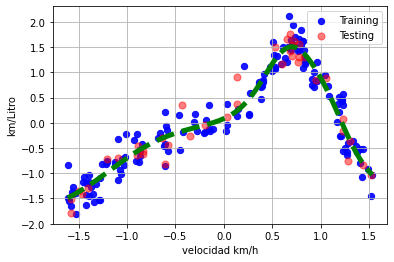

In [133]:
visualizar_ajuste_por_regresion(modelo, X_train, X_test, y_train, y_test,
                                feature_name=X.columns[0], target_name=y.name)

Una observación respecto del gráfico anterior es que cuando no se normalizan los datos los valores de testing y training se alejan de la curva punteada verde (regresión no lineal).

Adjunto foto de modelo no normalizado para agilizar el proceso:

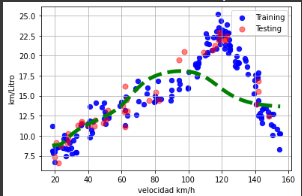

Se observa una regresión no lineal (polinomio).

**CURVA DE ERROR DE ENTRENAMIENTO**

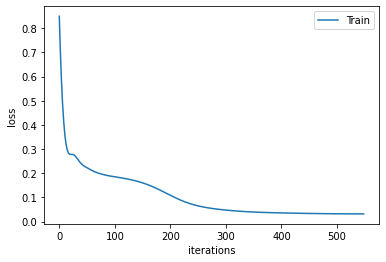

In [134]:
visualizar_curva_error_entrenamiento(modelo)

Curva de entrenamiento sin normalizar:

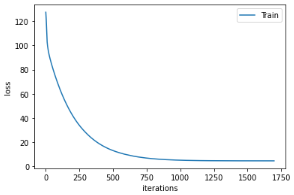

El Error Cuadrático Medio (ECM): Mide distancia entre puntos. Distancia euclídea al cuadrado.

a continuacion se observa que al normalizar el modelo tanto el ECM como el Error absoluto medio disminuyen considerablemente.

También se observa un r2 (se mide en valores absolutos) muy cercano a 1 (óptimo) lo cual es muy bueno. En cambio, sin normalizar los datos el r2 disminuye considerablemente para el test.

In [135]:
print(f'''
      train Error cuadrático medio: {round(mean_squared_error(y_train_predict, y_train), 2)}
      test Error cuadrático medio: {round(mean_squared_error(y_test_predict, y_test), 2)}

      train Error abs. medio: {round(mean_absolute_error(y_train_predict, y_train), 2)}
      test Error abs. medio: {round(mean_absolute_error(y_test_predict, y_test), 2)}

      train r2_score: {round(r2_score(y_train_predict, y_train), 2)}
      test r2_score: {round(r2_score(y_test_predict, y_test), 2)}
      ''')


      train Error cuadrático medio: 0.06
      test Error cuadrático medio: 0.05

      train Error abs. medio: 0.2
      test Error abs. medio: 0.17

      train r2_score: 0.93
      test r2_score: 0.95
      


Con un modelo sin normalizar, los errores tienen los siguientes valores:

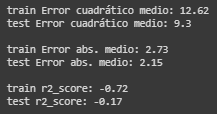